## Notebook Imports

In [10]:
from os import walk
from os.path import join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup

from wordcloud import WordCloud
from PIL import Image

from sklearn.model_selection import train_test_split

from typing import Iterator

## Constants

In [3]:
EXAMPLE_FILE = "SpamData/01_Processing/practice_email.txt"

SPAM_1_PATH = "SpamData/01_Processing/spam_assassin_corpus/spam_1"
SPAM_2_PATH = "SpamData/01_Processing/spam_assassin_corpus/spam_2"
EASY_NONSPAM_1_PATH = "SpamData/01_Processing/spam_assassin_corpus/easy_ham_1"
EASY_NONSPAM_2_PATH = "SpamData/01_Processing/spam_assassin_corpus/easy_ham_2"

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

TRAINING_DATA_FILE = "SpamData/02_Training/train-data.txt"
TEST_DATA_FILE = "SpamData/02_Training/test-data.txt"

WORD_ID_FILE = "SpamData/01_Processing/word-by-id.csv"
DATA_JSON_FILE = "SpamData/01_Processing/email-text-data.json"
WHALE_FILE = "SpamData/01_Processing/wordcloud_resources/whale-icon.png"
SKULL_FILE = "SpamData/01_Processing/wordcloud_resources/skull-icon.png"
THUMBS_UP_FILE = "SpamData/01_Processing/wordcloud_resources/thumbs-up.png"
THUMBS_DOWN_FILE = "SpamData/01_Processing/wordcloud_resources/thumbs-down.png"
CUSTOM_FONT_FILE = "SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf"

## Email body extraction

In [11]:
def email_body_generator(path: str) -> Iterator[tuple]:
    
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding="latin-1")
            
            is_body = False
            lines = []
            
            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == "\n":
                    is_body = True
            
            stream.close()
            
            email_body = "\n".join(lines)
            
            yield file_name, email_body

In [8]:
def df_from_directory(path: str, classification: int) -> pd.DataFrame:
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({"MESSAGE": email_body, "CATEGORY": classification})
        row_names.append(file_name)
    
    return pd.DataFrame(rows, index=row_names)

In [462]:
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, SPAM_CAT))
spam_emails.head()

,MESSAGE,CATEGORY
00249.5f45607c1bffe89f60ba1ec9f878039a,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1
00373.ebe8670ac56b04125c25100a36ab0510,ATTENTION: This is a MUST for ALL Computer Use...,1
00214.1367039e50dc6b7adb0f2aa8aba83216,This is a multi-part message in MIME format.\n...,1
00210.050ffd105bd4e006771ee63cabc59978,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1
00033.9babb58d9298daa2963d4f514193d7d6,This is the bottom line. If you can GIVE AWAY...,1


In [463]:
spam_emails.shape

(1898, 2)

In [464]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = spam_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))
ham_emails.head()

,MESSAGE,CATEGORY
00249.5f45607c1bffe89f60ba1ec9f878039a,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1
00373.ebe8670ac56b04125c25100a36ab0510,ATTENTION: This is a MUST for ALL Computer Use...,1
00214.1367039e50dc6b7adb0f2aa8aba83216,This is a multi-part message in MIME format.\n...,1
00210.050ffd105bd4e006771ee63cabc59978,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1
00033.9babb58d9298daa2963d4f514193d7d6,This is the bottom line. If you can GIVE AWAY...,1


In [465]:
ham_emails.shape

(3298, 2)

In [466]:
data = pd.concat([spam_emails, ham_emails])
print("Shape of entire dataframe is", data.shape)

Shape of entire dataframe is (5196, 2)


## Data Cleaning: Checking for Missing Values

In [467]:
data["MESSAGE"].isnull().values.any()

False

In [468]:
data.MESSAGE.isnull().sum()

0

In [469]:
# Check if there are empty emails
(data.MESSAGE.str.len() == 0).sum()

4

## Locate empty emails

In [470]:
type(data.MESSAGE.str.len() == 0)

pandas.core.series.Series

In [471]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds', 'cmds'], dtype='object')

## Remove System File Entries from Dataframe

In [472]:
data.drop(['cmds'], inplace=True)

In [473]:
data.shape

(5192, 2)

## Add Document IDs to Track Emails in Dataset

In [474]:
document_ids = range(0, len(data.index))
data["DOC_ID"] = document_ids

In [475]:
data["FILE_NAME"] = data.index
data.set_index("DOC_ID", inplace=True)

In [476]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5187,"I'm one of the 30,000 but it's not working ver...",0,00609.dd49926ce94a1ea328cce9b62825bc97
5188,Damien Morton quoted:\n\n>W3C approves HTML 4 ...,0,00957.e0b56b117f3ec5f85e432a9d2a47801f
5189,"On Mon, 2002-07-22 at 06:50, che wrote:\n\n\n\...",0,01127.841233b48eceb74a825417d8d918abf8
5190,"Once upon a time, Manfred wrote :\n\n\n\n> I w...",0,01178.5c977dff972cd6eef64d4173b90307f0
5191,"If you run Pick, and then use the ""New FTOC"" b...",0,00747.352d424267d36975a7b40b85ffd0885e


## Save to file

In [477]:
data.to_json(DATA_JSON_FILE)

# Number of Spam Messages Visualised 

In [478]:
data.CATEGORY.value_counts()

1    3792
0    1400
Name: CATEGORY, dtype: int64

In [479]:
amount_of_spam = data.CATEGORY.value_counts()[0]
amount_of_ham = data.CATEGORY.value_counts()[1]

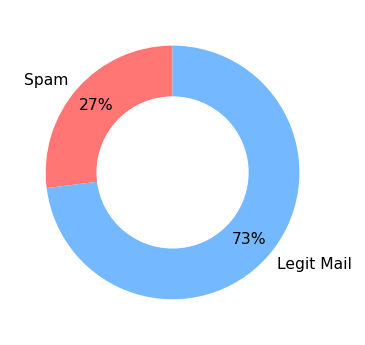

In [480]:
category_names = ["Spam", "Legit Mail"]
sizes = [amount_of_spam, amount_of_ham]
custom_colors = ["#ff7675", "#74b9ff"]

plt.figure(figsize=(3, 3), dpi=140)
plt.pie(sizes, labels=category_names, textprops={"fontsize": 8}, startangle=90, 
        autopct="%1.0f%%", colors=custom_colors, pctdistance=0.8)

# draw circle
centre_circle = plt.Circle((0,0), radius=0.6, fc="white")
plt.gca().add_artist(centre_circle)

plt.show()

## Text Pre-Processing

In [481]:
# Download the NLTK Resources (Tokenizer & Stopwords)
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/floriandreyer/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [482]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/floriandreyer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [483]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/floriandreyer/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     /Users/floriandreyer/nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

## Removing HTML Tags from emails

In [488]:
soup = BeautifulSoup(data.at[2, "MESSAGE"], "html.parser")
clean_email = str(soup.get_text())

## Function for Email Processing

In [489]:
def clean_message(message: str, stemmer: nltk.stem.porter.PorterStemmer = PorterStemmer() , stop_words: set = set(stopwords.words("english"))) -> list:
    
    soup = BeautifulSoup(message, "html.parser")
    cleaned_text = str(soup.get_text())
    
    words = word_tokenize(cleaned_text.lower())
    
    filtered_words = []
    
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [490]:
clean_message(data.at[2, "MESSAGE"])

['messag',
 'mime',
 'format',
 'dare',
 'tri',
 'find',
 'better',
 'annuiti',
 'guarante',
 'year',
 'surrend',
 'agent',
 'commiss',
 'age',
 'call',
 'today',
 'inform',
 'ext',
 'pleas',
 'fill',
 'form',
 'inform',
 'name',
 'phone',
 'citi',
 'state',
 'pmg',
 'financi',
 'servic',
 'deposit',
 'interest',
 'deposit',
 'total',
 'want',
 'anyon',
 'receiv',
 'mail',
 'wish',
 'receiv',
 'profession',
 'commun',
 'sent',
 'insur',
 'profession',
 'remov',
 'mail',
 'list',
 'repli',
 'messag',
 'instead',
 'go',
 'http',
 'legal',
 'notic',
 'dare',
 'find',
 'better',
 'annuiti',
 'call',
 'today',
 'inform',
 'pleas',
 'fill',
 'form',
 'inform',
 'name',
 'phone',
 'citi',
 'state',
 'deposit',
 'interest',
 'deposit',
 'total',
 'want',
 'anyon',
 'receiv',
 'mail',
 'wish',
 'receiv',
 'profession',
 'sent',
 'insur',
 'profession',
 'remov',
 'list',
 'repli',
 'messag',
 'instead',
 'go',
 'http',
 'legal',
 'notic']

## Apply Cleaning and Tokenisation to all messages

### Slicing Dataframes and Series & Creating Subsets

In [491]:
data.iat[2, 2]

'00214.1367039e50dc6b7adb0f2aa8aba83216'

In [492]:
data.iloc[0:11]

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1,00249.5f45607c1bffe89f60ba1ec9f878039a
1,ATTENTION: This is a MUST for ALL Computer Use...,1,00373.ebe8670ac56b04125c25100a36ab0510
2,This is a multi-part message in MIME format.\n...,1,00214.1367039e50dc6b7adb0f2aa8aba83216
3,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1,00210.050ffd105bd4e006771ee63cabc59978
4,This is the bottom line. If you can GIVE AWAY...,1,00033.9babb58d9298daa2963d4f514193d7d6
5,------=_NextPart_000_00B8_51E06B6A.C8586B31\n\...,1,00187.efd97ab2034b3384606e21db00014ecb
6,"<STYLE type=""text/css"">\n\n<!--\n\nP{\n\n fon...",1,00500.85b72f09f6778a085dc8b6821965a76f
7,<HR>\n\n<html>\n\n<head>\n\n <title>Secured I...,1,00493.1c5f59825f7a246187c137614fb1ea82
8,"<table width=""600"" border=""20"" align=""center"" ...",1,00012.381e4f512915109ba1e0853a7a8407b2


In [493]:
first_emails = data.MESSAGE.iloc[0:3]
nested_list = first_emails.apply(clean_message)

In [494]:
flat_list = [item for sublist in nested_list for item in sublist]

In [495]:
%%time
nested_list = data.MESSAGE.apply(clean_message)

CPU times: user 30.9 s, sys: 394 ms, total: 31.3 s
Wall time: 32.2 s


In [496]:
print(nested_list)

DOC_ID
0       [dear, homeown, interest, rate, lowest, point,...
1       [attent, must, comput, user, packag, deal, nor...
2       [messag, mime, format, dare, tri, find, better...
3       [import, inform, new, domain, name, final, ava...
4       [bottom, line, give, away, cd, free, peopl, li...
                              ...                        
5187    [one, work, well, week, te, updat, server, syn...
5188    [damien, morton, quot, approv, html, abl, say,...
5189    [mon, che, wrote, that, correct, line, ad, rep...
5190    [upon, time, manfr, wrote, would, like, instal...
5191    [run, pick, use, new, ftoc, button, show, mess...
Name: MESSAGE, Length: 5192, dtype: object


## Slice Dataframes

In [497]:
ham_emails_idx = data[data.CATEGORY == 1].index
spam_emails_idx = data[data.CATEGORY == 0].index

In [498]:
nested_list_ham = nested_list.loc[ham_emails_idx]

In [499]:
nested_list_spam = nested_list.loc[spam_emails_idx]

In [500]:
nested_list_spam.shape

(1400,)

In [501]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()

normal_words[:10]

http      6194
email     6180
free      5170
click     4116
receiv    3978
list      3942
get       3828
pleas     3704
busi      3584
order     3492
dtype: int64

In [502]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]

In [503]:
print(f"Number of words in ham emails: {len(flat_list_ham)}, number of words in spam emails: {len(flat_list_spam)}")

Number of words in ham emails: 634998, number of words in spam emails: 180669


# Wordcloud of Ham and Spam emails

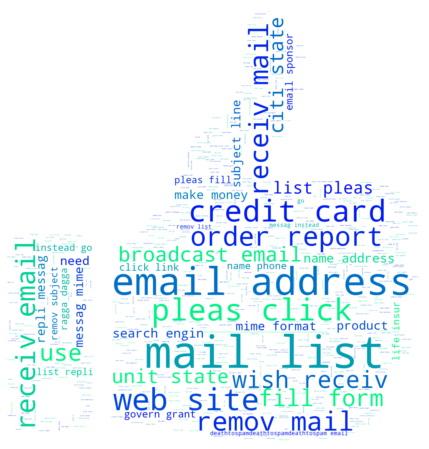

In [509]:
plt.figure(figsize=[16, 8])

icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode="RGB", size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask)

word_cloud = WordCloud(mask=rgb_array, background_color="white", max_words=600, colormap="winter")
word_cloud.generate(' '.join(flat_list_ham))
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

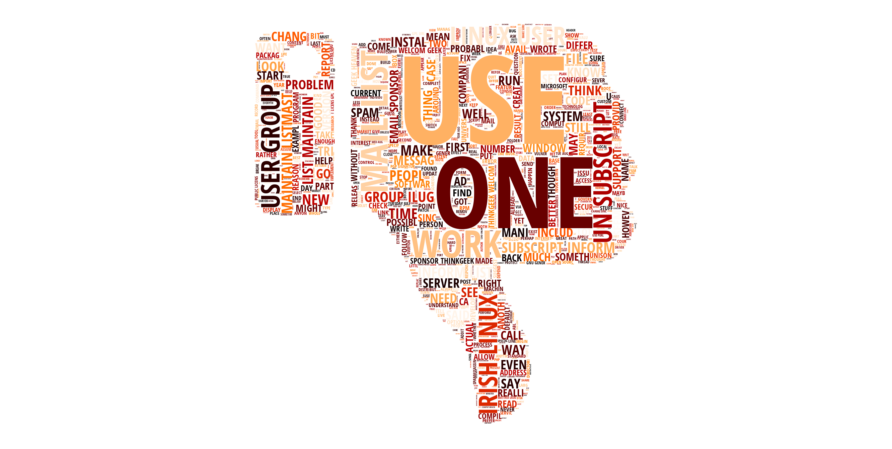

In [510]:
plt.figure(figsize=[16, 8])

icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode="RGB", size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask)

word_cloud = WordCloud(mask=rgb_array, background_color="white", max_words=2000, colormap="gist_heat", font_path=CUSTOM_FONT_FILE)
word_cloud.generate(' '.join(flat_list_spam).upper())
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Generate Vocabulary & Dictionary

In [511]:
stemmed_nested_list = data.MESSAGE.apply(clean_message)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

In [512]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print("Nr of unique words", unique_words.shape[0])
unique_words.head()

Nr of unique words 20514


http     9445
email    6769
list     5436
free     5340
get      4733
dtype: int64

In [513]:
frequent_words = unique_words[:VOCAB_SIZE]
print("Most common words: \n", frequent_words[:10])

Most common words: 
 http      9445
email     6769
list      5436
free      5340
get       4733
mail      4473
use       4281
receiv    4166
click     4146
one       4103
dtype: int64


# Create Vocabulary DataFrame with a WORD_ID

In [514]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({"VOCAB_WORD": frequent_words.index.values}, index=word_ids)
vocab.index.name = "WORD_ID"
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,email
2,list
3,free
4,get


## Save the Vocabulary as a CSV File

In [515]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

Checking if a Word is Part of the Vocabulary

In [516]:
words = ["machine", "learning", "fun", "learn", "data", "science", "app", "brewery"]

for word in words:
    print(word in set(vocab.VOCAB_WORD))

False
False
True
True
True
False
True
False


Find the Email with the Most Number of Words

In [517]:
clean_email_lengths = [len(sublist) for sublist in stemmed_nested_list]

print(f"Longest email has {max(clean_email_lengths)} words.")

Longest email has 7671 words.


In [518]:
index_longest_email = clean_email_lengths.index(max(clean_email_lengths)) # Alternative np.argmax(clean_email_lengths)
print("Longest email: \n", stemmed_nested_list[index_longest_email])

Longest email: 
 ['yahoo', 'group', 'sponsor', 'dvd', 'free', 'p', 'join', 'http', 'new', 'version', 'unison', 'avail', 'test', 'incorpor', 'sever', 'small', 'improv', 'main', 'chang', 'fix', 'bug', 'potenti', 'seriou', 'safeti', 'consequ', 'small', 'number', 'user', 'habit', 'run', 'one', 'instanc', 'unison', 'time', 'parallel', 'user', 'strongli', 'encourag', 'upgrad', 'other', 'wait', 'wish', 'releas', 'includ', 'execut', 'linux', 'solari', 'window', 'look', 'maintain', 'moment', 'none', 'activ', 'develop', 'regularli', 'use', 'unison', 'window', 'machin', 'configur', 'properli', 'build', 'execut', 'export', 'grab', 'http', 'enjoy', 'benjamin', 'chang', 'sinc', 'ad', 'prefer', 'maxthread', 'use', 'limit', 'number', 'simultan', 'file', 'transfer', 'ad', 'backupdir', 'prefer', 'control', 'backup', 'file', 'store', 'basic', 'support', 'ad', 'osx', 'particular', 'unison', 'recogn', 'one', 'host', 'synchron', 'run', 'osx', 'switch', 'treatment', 'filenam', 'consid', 'file', 'osx', 'yet',

In [519]:
data.iloc[index_longest_email]

MESSAGE      ------------------------ Yahoo! Groups Sponsor...
CATEGORY                                                     0
FILE_NAME               01380.e3fad5af747d3a110008f94a046bf31b
Name: 4797, dtype: object

In [520]:
data.at[np.argmax(clean_email_lengths), "MESSAGE"]

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

# Generate Features & a Sparse Matrix

## Creating a DataFrame with one Word per Column

In [521]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())

In [522]:
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,dear,homeown,interest,rate,lowest,point,year,help,find,best,...,None,None,None,None,None,None,None,None,None,None
1,attent,must,comput,user,packag,deal,norton,systemwork,softwar,suit,...,None,None,None,None,None,None,None,None,None,None
2,messag,mime,format,dare,tri,find,better,annuiti,guarante,year,...,None,None,None,None,None,None,None,None,None,None
3,import,inform,new,domain,name,final,avail,gener,public,discount,...,None,None,None,None,None,None,None,None,None,None
4,bottom,line,give,away,cd,free,peopl,like,one,month,...,None,None,None,None,None,None,None,None,None,None


In [523]:
word_columns_df.shape

(5192, 7671)

### Splitting the Data into a Training and Testing Dataset

In [524]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY, test_size=0.3, random_state=42)

In [525]:
X_train.index.name = X_test.index.name = "DOC_ID"

In [526]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
3547,public,announc,new,domain,name,final,avail,gener,public,discount,...,None,None,None,None,None,None,None,None,None,None
79,best,mortag,rate,simpl,easi,free,hundr,lender,compet,loan,...,None,None,None,None,None,None,None,None,None,None
4783,pgp,sign,messag,secur,advisori,freebsd,project,topic,bug,nf,...,None,None,None,None,None,None,None,None,None,None
4443,suggest,see,valid,need,server,avail,local,smtp,host,recurs,...,None,None,None,None,None,None,None,None,None,None
4294,tue,aug,wintermut,wrote,rick,moen,wrote,like,suse,product,...,None,None,None,None,None,None,None,None,None,None


### Create a Sparse Matrix for the Training Data

In [527]:
word_index = pd.Index(vocab.VOCAB_WORD)

In [528]:
def make_sparse_matrix(df: pd.DataFrame, indexed_words: pd.Index, labels: list) -> pd.DataFrame:
    """
    Returns sparse matrix as dataframe
    
    df: A dataframe with words in the columns with a document id as an index (X_train or X_test)
    indexed_words: index of words ordered by word id
    labels: category as a series (y_train or y_test)
    """
    nr_rows = df.shape[0]
    nr_columns = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_columns):
            
            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {"LABEL": category, "DOC_ID": doc_id, "OCCURENCE": 1, "WORD_ID": word_id}
                
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)

In [529]:
%%time
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

CPU times: user 5min, sys: 1.39 s, total: 5min 1s
Wall time: 5min 2s


In [530]:
sparse_train_df.head()

,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,0,4970,1,593
1,0,4970,1,17
2,0,4970,1,178
3,0,4970,1,316
4,0,4970,1,575


In [531]:
sparse_train_df.shape

(495768, 4)

## Combine Occurrences with the Pandas groupby() Method

In [532]:
train_grouped = sparse_train_df.groupby(["DOC_ID", "WORD_ID", "LABEL"]).sum().reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,0,1,2
1,0,3,1,1
2,0,10,1,1
3,0,22,1,1
4,0,34,1,1


In [533]:
train_grouped.shape

(271475, 4)

In [534]:
train_grouped.tail()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
271470,5189,802,0,1
271471,5189,815,0,1
271472,5189,1234,0,1
271473,5189,1538,0,1
271474,5189,1874,0,1


## Save Training Data as .txt File

In [535]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt="%d")

# Test Data

In [536]:
%%time
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

CPU times: user 2min 7s, sys: 335 ms, total: 2min 7s
Wall time: 2min 7s


In [537]:
test_grouped = sparse_test_df.groupby(["DOC_ID", "WORD_ID", "LABEL"]).sum().reset_index()
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,8,3,1,1
1,8,8,1,2
2,8,15,1,1
3,8,17,1,1
4,8,31,1,1


In [538]:
test_grouped.shape

(115204, 4)

In [539]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt="%d")

In [540]:
shape_grouped = sparse_test_df.groupby(["DOC_ID", "LABEL"]).sum().reset_index()
shape_grouped.shape

(1523, 4)